In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats

# Description

Lets say we constructed a model for the data `Y`. The data `Y` is normally distributed centered around a parameter called `weight` with some standard deviation chosen as `1` here, so `P(Y | weight) = N(weight, 1)`. We also model the distribution of the weight itself as `P(weight) = N(weight, 1)`. This distribution is called the prior and is the distribution of `weight` if we don't have any data `Y`. If we are given some samples of `Y` how is it possible to figure out the distribution of `weight` that produced these `Y`?
Bayes theorem states that the distribution of `weight` given `Y` can be calculated: `P(weight | Y) = P(Y | weight) * P(weight) / P(Y)`. With the above model we can already calculate `P(Y | weight)` and `P(weight)`.
For example assume we defined a prior `P(weight) = N(0, 10)` and a likelihood function `P(Y | weight) = N(weight, 5)`. If we have `weight = 0.5` we can calculate its prior probability `P(weight) = P(0.5) = N(0.5 | 0, 10) = 0.0398`. Furthermore if we have some samples `Y = [-1, -0.5, 1]` we can calculate their probability given the weight and the likelihood function `P(Y | weight) = N(-1 | 0.5, 5) * N(-0.5 | 0.5, 5) * N(1 | 0.5, 5) = 0.0763 * 0.0782 * 0.0794 = 0.000474`. The joint probability is then `P(Y | weight) * P(weight) = 0.000474 * 0.0398 = 0.0000189`. However we don't have the denominator `P(Y)` and while `P(Y)` could be calculated by integrating `P(Y | weight)` over all possible weights this is not possible in practice.
What we can do instead is use a sampling algorithm to get samples of `P(weight | Y)`. After taking enough samples we should see the shape of distribution by plotting a histogram of the samples. One such sampling algorithm is the Metropolis-Hastings algorithm. It keeps a list of samples for the weights for each step. An arbitrary initial value for weight is chosen. A new weight around the old one is calculated for example by sampling from `N(weight, 1)`. Then a rejection ratio is calculated from the joint probabilities of the old and the new weight under the given Y. These are calculated like in the example before. The rejection ratio is then `r = NewJointProb / OldJoint Prob`. We then we decide to keep the new weight sample if `r` is greater than a sample from `U(0, 1)` which means we are likely to keep weight samples that have a higher joint probability. In the end we will have samples of weights whose distribution approximates `P(weight | Y)`.

Below is an example that first generates 30 samples of `weight` from a `N(-1, 0.5)` distribution and `Y` out of a `N(weight, 0.5)` distribution. In the next step we define the prior `P(weight) = N(0, 10)` and the likelihood function `P(Y | weight) = N(weight, 5)`. Then the Metropolis-Hastings algorithm is used to draw samples from `P(weight | Y)`. Finally we plot a histogram of these samples and we can see that the original weight distribution (`N(-1, 0.5)`) is approximated by it.

An important detail for doing this numerically is that as seen above when calculating `P(Y | weight)` we multiply a lot of small values together, so doing it naively would not work. Instead we operate on log probabilities where multiplication becomes addition and later convert back to probabilities by exponentiating.

TL;DR:
- Weight prior: `P(weight) = N(0, 10)`
- Likelihood of Y given weight: `P(Y | weight) = N(weight, 5)`
- Given some Y samples, figure out the distribution of weight by sampling from `P(weight | Y)` using Metropolis-Hastings which uses only the given `Y`, `P(weight) and P(Y | weight)`

# 1. Sample data generation

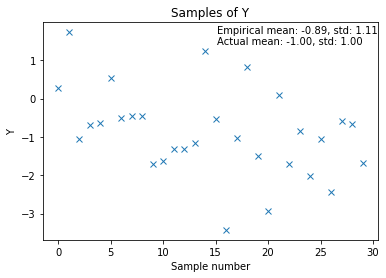

In [2]:
# Prior: P(weight) = N(0, 10)
# Likelihood function: P(y | weight) = N(weights, 5)
# Posterior: P(weight | y) = P(y | weight) * P(weight) / P(y)
# Can't calculate P(y) which would be P(y | weight) integrated over all weights.
# Sample using the "joint probability" P(y | weight) * P(weight) instead.

# Ground truth weights distribution: N(-1, 0.5)
gt_weight_mean = -1
gt_weight_std = 0.5

# Ground truth Y distribution: N(weights, 1)
gt_y_std = 1

# Draw samples from ground truth Y distribution
num_gts = 30

gt_y = np.empty(num_gts, dtype=np.float32)
np.random.seed(0)
for i in range(num_gts):
    # Sample weight from N(-1, 0.5)
    gt_weight = np.random.normal(loc=gt_weight_mean, scale=gt_weight_std)

    # Sample y from N(weight, 1)
    gt_y[i] = np.random.normal(loc=gt_weight, scale=gt_y_std)

# Plot samples
plt.title("Samples of Y")
plt.xlabel("Sample number")
plt.ylabel("Y")
plt.annotate("Empirical mean: %.2f, std: %.2f" % (np.mean(gt_y), np.std(gt_y)), [0.52, 0.95], xycoords="axes fraction")
plt.annotate("Actual mean: %.2f, std: %.2f" % (gt_weight_mean, gt_y_std), [0.52, 0.9], xycoords="axes fraction")
plt.plot(gt_y, linestyle="None", marker="x")
plt.show()

# 2. Use Metropolis-Hastings to get samples of weights

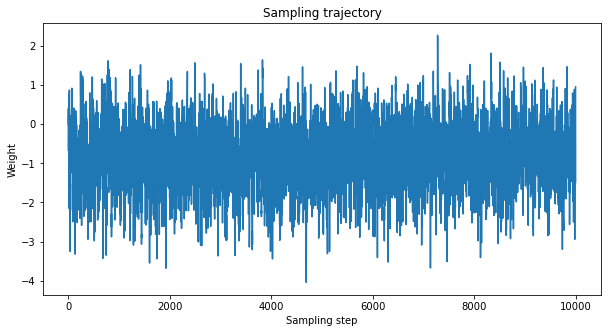

In [3]:
# P(weight) = N(0, 10)
prior_weight_mean = 0
prior_weight_std = 10
prior_weight = scipy.stats.norm(prior_weight_mean, prior_weight_std)

# P(y | weight) = N(weight, 5)
likelihood_std = 5

# We use logarithmic probabilities everywhere since multiplying so many
# small numbers together doesn't work numerically.

def calculate_log_joint_prob(weight):
    """Calculate log(P(y | weight) * P(weight) = log_P(y | weight) + log_P(weight)."""
    # log_P(weight) = N(0, 10)
    log_p_weight = prior_weight.logpdf(weight)

    # log_P(y | weight) = N(weight, 5)
    log_p_likelihood = np.sum(scipy.stats.norm(weight, likelihood_std).logpdf(gt_y))

    # log_P(y | weight) + log_P(weight)
    return log_p_likelihood + log_p_weight

def should_accept(joint_log_prob_new, joint_log_prob_old):
    """Compare the joint probabilities of two weights and return
    whether the new weight should be kept.
    r = (P(y | new_weight) * P(new_weight)) / (P(y | old_weight) * P(old_weight))
    Accept new weight if r > sample from U(0, 1).
    """
    return np.exp(joint_log_prob_new - joint_log_prob_old) > np.random.uniform()

def next_sample(weight_old):
    """Calculate next sample using N(weight_old, 1)"""
    return np.random.normal(loc=weight_old, scale=1)

np.random.seed(0)

num_samples = 10000

samples = np.empty(num_samples, dtype=np.float32)

# Set initial weight to 0 and calculate its joint probability
weight = 0
joint_log_prob = calculate_log_joint_prob(weight)

# Draw some samples
for i in range(num_samples):
    # Get the next weight and calculate its joint probability
    next_weight = next_sample(weight)
    next_joint_log_prob = calculate_log_joint_prob(next_weight)

    # Check if we should keep the old or the new weight
    if should_accept(next_joint_log_prob, joint_log_prob):
        weight = next_weight
        joint_log_prob = next_joint_log_prob

    # Add weight to samples (will be either the previous one or the new one)
    samples[i] = weight

# Plot the sampling trajectory
plt.figure(figsize=[10, 5])
plt.xlabel("Sampling step")
plt.ylabel("Weight")
plt.title("Sampling trajectory")
plt.plot(samples)
plt.show()

# 3. Plot histograms of weight samples which will approximate P(weight | Y)

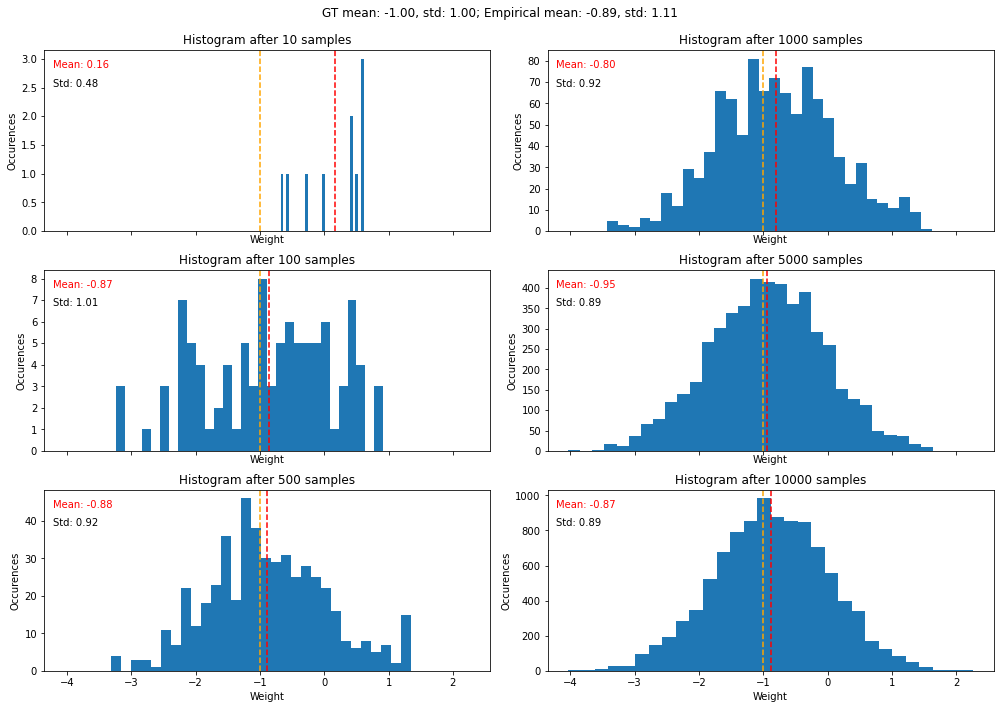

In [4]:
fig, axes = plt.subplots(3, 2, sharex=True, figsize=[14, 10])
fig.suptitle("GT mean: %.2f, std: %.2f; Empirical mean: %.2f, std: %.2f" % (gt_weight_mean, gt_y_std, np.mean(gt_y), np.std(gt_y)))
for i, sample_count in enumerate([10, 100, 500, 1000, 5000, 10000]):
    samples_subset = samples[:sample_count]
    ax = axes[i % 3, i // 3]
    ax.hist(samples_subset, bins=30)
    ax.axvline(gt_weight_mean, c="orange", linestyle="dashed")
    ax.axvline(np.mean(samples_subset), c="red", linestyle="dashed")
    ax.set_title("Histogram after %d samples" % sample_count)
    ax.set_xlabel("Weight")
    ax.set_ylabel("Occurences")
    ax.annotate("Mean: %.2f" % np.mean(samples_subset), [0.02, 0.9], xycoords="axes fraction", c="red")
    ax.annotate("Std: %.2f" % np.std(samples_subset), [0.02, 0.8], xycoords="axes fraction")
fig.tight_layout()
fig.subplots_adjust(top=0.92)
fig.show()